Notebook for testing density estimation.

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t
from scipy.stats import norm


from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from sklearn.neighbors import KernelDensity

In [2]:
# Dados
data_path = "../data/processed/"
returns_path = ''.join([data_path, 'ibovespa_treated.xlsx'])
df = pd.read_excel(returns_path, index_col="time")
df.head()

,2024-12-02,2024-12-03,2024-12-04,2024-12-05,2024-12-06,2024-12-09,2024-12-10,2024-12-11,2024-12-12,2024-12-13,...,2025-11-14,2025-11-17,2025-11-18,2025-11-19,2025-11-21,2025-11-24,2025-11-25,2025-11-26,2025-11-27,2025-11-28
time,,,,,,,,,,,,,,,,,,,,,
10:00:00,0.000011,-0.000372,-0.000035,0.007233,-0.001305,-0.000459,0.002388,0.002212,-0.008001,-0.000824,...,-0.000957,-0.002307,-0.003734,-0.005020,-0.001139,-0.000255,0.002339,0.004176,-0.000224,-0.000238
10:05:00,-0.002271,0.003372,0.001716,0.005538,0.000069,0.006429,0.002343,0.001918,-0.007582,-0.000413,...,-0.001522,0.000739,-0.000613,0.000306,-0.002021,-0.000810,0.001557,-0.001565,-0.000193,0.002906
10:10:00,-0.000582,0.002832,-0.000502,0.000739,0.000261,0.001891,0.000775,-0.001172,0.000216,-0.000432,...,0.000360,-0.000105,-0.000159,-0.000362,0.000092,0.001131,0.001170,0.000202,0.000556,0.000475
10:15:00,-0.001997,0.001091,0.000111,-0.000192,0.000407,-0.001392,-0.000477,-0.001526,0.000198,-0.001821,...,0.001121,-0.000284,0.003272,-0.001107,-0.001012,-0.000174,0.001002,0.001815,-0.000168,0.000973
10:20:00,-0.000037,-0.000505,-0.000327,-0.000580,-0.000436,-0.000405,0.001263,0.000676,-0.002667,0.001033,...,0.000449,0.000335,0.000853,0.000981,-0.000057,-0.000096,0.000832,0.001951,0.001060,-0.001004


In [3]:
t = 0

x = df.iloc[:,t].values

In [4]:
kde_scipy = gaussian_kde(x, bw_method="silverman")

kde_statsmodels = KDEUnivariate(x)
kde_statsmodels.fit(bw="silverman", kernel="gau")

kde_sklearn = KernelDensity(kernel="gaussian", bandwidth=0.001).fit(x[:, None])

In [5]:
M = 256
x_support = np.linspace(x.min(), x.max(), 100)

pdf_scipy = kde_scipy(x_support)
pdf_statsmodels = kde_statsmodels.evaluate(x_support)
log_pdf_sklearn = kde_sklearn.score_samples(x_support[:, None])
pdf_sklearn = np.exp(log_pdf_sklearn)

[]

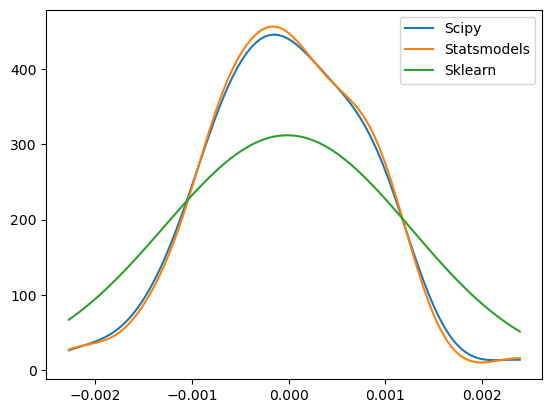

In [6]:
plt.figure()


plt.plot(x_support, pdf_scipy, label="Scipy")
plt.plot(x_support, pdf_statsmodels, label="Statsmodels")
plt.plot(x_support, pdf_sklearn, label="Sklearn")

plt.legend()

plt.plot()

# t-kernel

In [ ]:
import seaborn as sns
# plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

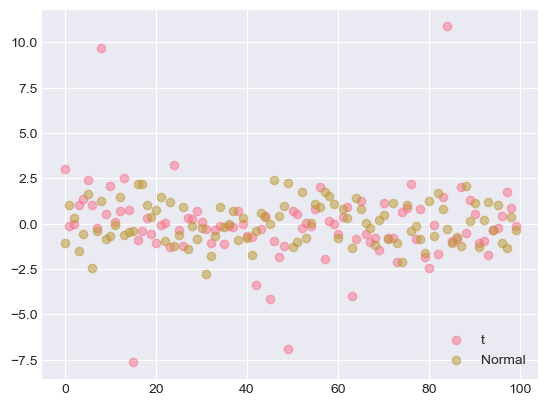

In [34]:
theoretical_deg_freedom = 3
n = 100

np.random.seed(123)
# data = t.rvs(df=theoretical_deg_freedom, size=n)

normal_samples = np.random.normal(loc=0, scale=1, size=n)
t_samples = np.random.standard_t(df=theoretical_deg_freedom, size=n)

plt.figure()
plt.scatter(np.arange(n),t_samples, label="t", alpha=.5)
plt.scatter(np.arange(n),normal_samples, label="Normal", alpha=.5)

plt.legend()

plt.show()

In [35]:
n = len(t_samples)
h = 1.06 * np.std(t_samples, ddof=1) * n ** (-1/5)

In [100]:
def t_kde(y, x, h, df=3):
    """
    Adaptive Student-t kernel density estimator (KDE).

    This function implements a kernel density estimator with a Student-t kernel
    and *observation-specific bandwidths*. The estimator is given by

        \hat f(y)
        = (1 / n) * sum_{i=1}^n (1 / h_i)
          t_df((y - x_i) / h_i),

    where t_df(·) denotes the Student-t probability density function with `df`
    degrees of freedom and h_i > 0 is the bandwidth associated with observation x_i.

    Parameters
    ----------
    y : array_like, shape (m,)
        Points at which the density is evaluated.
    x : array_like, shape (n,)
        Sample observations.
    h : float or array_like, shape (n,)
        Bandwidth(s). If a scalar is provided, a common bandwidth is used for all
        observations. If an array is provided, each observation x_i uses its own
        bandwidth h_i.
    df : int, optional (default=3)
        Degrees of freedom of the Student-t kernel. Smaller values yield heavier
        tails and increased robustness to outliers.

    Returns
    -------
    kde : ndarray, shape (m,)
        Estimated density values evaluated at each point in `y`.
    """

    # Ensure y is a 1D array to allow vectorized evaluation.
    y = np.atleast_1d(y)

    # Convert data to NumPy arrays.
    x = np.asarray(x)
    h = np.asarray(h)

    # If a scalar bandwidth is provided, replicate it for each observation.
    # This ensures h has shape (n,), matching the data dimension.
    if h.ndim == 0:
        h = np.full_like(x, h, dtype=float)

    # Enforce that each observation has a corresponding bandwidth.
    if len(h) != len(x):
        raise ValueError("Length of h must match length of x")

    # Compute standardized distances using observation-specific bandwidths:
    #
    #   u_ij = (y_i - x_j) / h_j
    #
    # The resulting matrix has shape (m, n), where:
    #   - m = number of evaluation points
    #   - n = sample size
    u = (y[:, None] - x[None, :]) / h[None, :]

    # Evaluate the Student-t kernel at each standardized distance and
    # apply the normalization factor 1 / h_j for each observation:
    #
    #   \hat f(y_i) = (1 / n) * sum_{j=1}^n
    #                [ t_df(u_ij) / h_j ]
    #
    # Averaging over axis=1 aggregates contributions across observations.
    kde = np.mean(t.pdf(u, df=df) / h[None, :], axis=1)

    # Return the adaptive KDE evaluated at y.
    return kde


def gaussian_kde_manual(y, x, h):
    u = (y[:, None] - x[None, :]) / h
    return np.mean(norm.pdf(u), axis=1) / h

<>:8: SyntaxWarning: invalid escape sequence '\h'
<>:8: SyntaxWarning: invalid escape sequence '\h'
C:\Users\user\AppData\Local\Temp\ipykernel_19352\3687429397.py:8: SyntaxWarning: invalid escape sequence '\h'
  \hat f(y)


In [101]:
grid = np.linspace(
    t_samples.min() - 3 * h,
    t_samples.max() + 3 * h,
    400
)

In [104]:
kde_t = t_kde(grid, t_samples, h, df=theoretical_deg_freedom)
kde_gauss = gaussian_kde_manual(grid, t_samples, h)

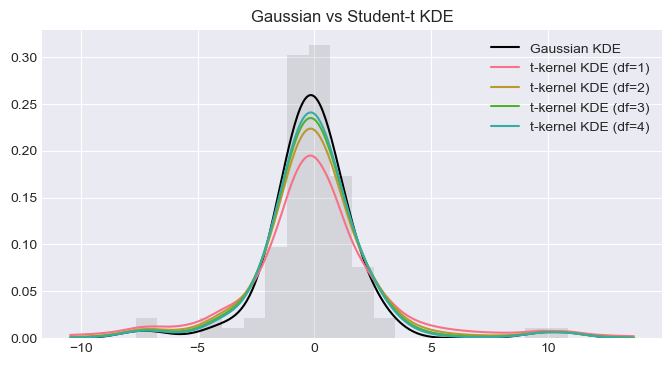

In [105]:
plt.figure(figsize=(8, 4))
plt.plot(grid, kde_gauss, color="black", label="Gaussian KDE")

for df in range(1,5):
    kde_t = t_kde(grid, t_samples, h, df=df)
    plt.plot(grid, kde_t, , label=f"t-kernel KDE (df={df})")

plt.hist(t_samples, bins=20, density=True, alpha=0.2, color="gray")
plt.legend()
plt.title("Gaussian vs Student-t KDE")
plt.show()

In [146]:

def rule_of_thumb_bandwidth(
        x, 
        rule="silverman"
    ):
    """
    Estimate bandwidth using a rule-of-thumb method.

    Implements Scott's rule and Silverman's rule for
    univariate kernel density estimation.

    Parameters
    ----------
    x : array-like, shape (n_samples,)
        One-dimensional sample.
    rule : {"silverman", "scott"}, default="silverman"
        Bandwidth selection rule.

    Returns
    -------
    h : float
        Estimated bandwidth.

    Notes
    -----
    Scott's rule:
        h = sigma * n^{-1/5}

    Silverman's rule:
        h = 0.9 * min(sigma, IQR / 1.34) * n^{-1/5}

    where sigma is the sample standard deviation and IQR is the
    interquartile range.

    References
    ----------
    Scott, D. W. (1992). Multivariate Density Estimation.
    Silverman, B. W. (1986). Density Estimation for Statistics
    and Data Analysis.
    """
    x = np.asarray(x, dtype=float)
    if x.ndim != 1:
        raise ValueError("x must be one-dimensional")

    n = len(x)
    if n < 2:
        raise ValueError("At least two observations are required")

    sigma = np.std(x, ddof=1)

    if rule.lower() == "scott":
        return sigma * n ** (-1 / 5)

    elif rule.lower() == "silverman":
        q75, q25 = np.percentile(x, [75, 25])
        iqr = q75 - q25
        scale = min(sigma, iqr / 1.34)
        return 0.9 * scale * n ** (-1 / 5)

    else:
        raise ValueError("rule must be 'silverman' or 'scott'")

In [225]:
class FDA_KDE:
    """
    Description
    ---------
    Kernel Density Estimation for (functional) data.

    Supports multiple kernels and observation-specific bandwidths.

    Example
    ---------
    >>>x1 = np.random.randn(200)
    >>>x2 = np.random.standard_t(df=3, size=200)
    >>>grid = np.linspace(-4, 4, 400)

    >>>kde = FDA_KDE(kernel="gaussian", bandwidth=0.3)
    >>>density = kde.fit_transform(x1, grid)
    """

    def __init__(
            self, 
            kernel="gaussian", 
            bandwidth=1.0, 
            **kernel_params
            ):
        """
        Parameters
        ----------
        kernel : str
            Kernel name. Available: 'gaussian', 't_student', 'epanechnikov'.
        bandwidth : float or array-like
            Scalar or observation-specific bandwidth(s).
        **kernel_params :
            Additional parameters passed to the kernel
            (e.g., df for Student-t kernel).
        """
        self.kernel = kernel
        self.bandwidth = bandwidth
        self.kernel_params = kernel_params

        # Kernel registry (instance-level, extensible)
        self._kernel_map = {
            "gaussian": self._gaussian_kernel,
            "t_student": self._t_student_kernel,
            "epanechnikov": self._epanechnikov_kernel,
        }

        # Attributes set after fitting
        self.X_   = None
        self.h_   = None
        self.grid = None

    # ------------------------------------------------------------------
    # Public API
    # ------------------------------------------------------------------

    def fit(
            self, 
            X,
            adaptive:bool
        ):
        """
        Store training data and validate bandwidth.

        Parameters
        ----------
        X : array-like, shape (n_samples,)
            Training observations.

        Returns
        -------
        self
        """
        X = np.asarray(X, dtype=float)
        if X.ndim != 1:
            raise ValueError("X must be one-dimensional")
        
        self.X_ = X
        
        # Step 1: global bandwidth
        if isinstance(self.bandwidth, str):
            h0 = rule_of_thumb_bandwidth(X, self.bandwidth)
        else:
            h0 = float(self.bandwidth)

        # Step 2: adaptive adjustment (optional)
        if adaptive:
            self.h_ = self._adaptive_bandwidth(X, h0)
        else:
            self.h_ = np.full_like(X, h0)

        return self

    def transform(
            self, 
            grid
        ):
        """
        Evaluate the KDE on a given grid.

        Parameters
        ----------
        grid : array-like, shape (n_grid,)
            Evaluation points.

        Returns
        -------
        density : ndarray, shape (n_grid,)
            Estimated density values.
        """
        self._check_is_fitted()

        grid = np.asarray(grid, dtype=float)

        # Standardized distances: u_ij = (grid_i - X_j) / h_j
        u = (grid[:, None] - self.X_[None, :]) / self.h_[None, :]

        pdf = self._evaluate_kernel(u)

        # KDE: mean_j K(u_ij) / h_j
        density = np.mean(pdf / self.h_[None, :], axis=1)

        return density

    def fit_transform(
            self, 
            X : np.array, 
            m : int = 256,
            adaptive : bool = False):
        """
        Fit the model and evaluate the KDE on a grid.
        """
        grid = np.linspace(X.min(), X.max(), m)

        self.grid = grid
        return self.fit(X, adaptive=adaptive).transform(grid)

    # ------------------------------------------------------------------
    # Kernel evaluation
    # ------------------------------------------------------------------


    def _gaussian_kernel(self, u):
        """
        Gaussian kernel.
        """
        return norm.pdf(u)

    def _t_student_kernel(self, u, df=5):
        """
        Student-t kernel.

        Parameters
        ----------
        df : int
            Degrees of freedom.
        """
        return t.pdf(u, df=df)
    
    def _epanechnikov_kernel(u):
        """
        Epanechnikov kernel.
        """
        return 0.75 * (1 - u**2) * (np.abs(u) <= 1)
 
    def _evaluate_kernel(
            self, 
            u : np.array
        ) -> np.array:
        """
        Evaluate the selected kernel on standardized distances.

        This method dispatches the evaluation of the kernel function
        specified by ``self.kernel`` using the internal kernel registry.
        The kernel is evaluated pointwise on the standardized distances

            u_ij = (x_i - X_j) / h_j,

        where ``x_i`` are evaluation points, ``X_j`` are training
        observations, and ``h_j`` are observation-specific bandwidths.

        Parameters
        ----------
        u : ndarray, shape (n_grid, n_samples)
            Matrix of standardized distances between evaluation points
            and training observations.

        Returns
        -------
        pdf : ndarray, shape (n_grid, n_samples)
            Kernel values evaluated at ``u``.

        Raises
        ------
        ValueError
            If ``self.kernel`` is not a recognized kernel name.

        Notes
        -----
        This method assumes that the selected kernel integrates to one.
        Bandwidth scaling is applied outside this function when computing
        the KDE estimator.
        """
        try:
            kernel_fn = self._kernel_map[self.kernel]
        except KeyError:
            raise ValueError(
                f"Unknown kernel '{self.kernel}'. "
                f"Available kernels: {list(self._kernel_map)}"
            )

        kde = kernel_fn(u, **self.kernel_params)
        
        return kde

    # ------------------------------------------------------------------
    # Utilities
    # ------------------------------------------------------------------

    @staticmethod
    def _validate_bandwidth(bandwidth, X):
        """
        Validate and broadcast bandwidth to match X.
        """
        h = np.asarray(bandwidth, dtype=float)

        if h.ndim == 0:
            h = np.full_like(X, h)

        if h.ndim != 1 or len(h) != len(X):
            raise ValueError(
                "bandwidth must be a scalar or an array with "
                "the same length as X"
            )

        if np.any(h <= 0):
            raise ValueError("bandwidth values must be positive")

        return h

    def _check_is_fitted(self):
        if self.X_ is None or self.h_ is None:
            raise RuntimeError("The estimator is not fitted yet.")
        
    def _pilot_density(self, X, h):
        """
        Compute pilot density estimate at sample points.
        """
        u = (X[:, None] - X[None, :]) / h
        pdf = self._gaussian_kernel(u)  # pilot is Gaussian by convention
        return np.mean(pdf / h, axis=1)
        
    def _adaptive_bandwidth(self, X, h):
        """
        Compute adaptive (Abramson) bandwidths.
        """
        f_pilot = self._pilot_density(X, h)

        # Numerical safety
        eps = np.finfo(float).eps
        f_pilot = np.maximum(f_pilot, eps)

        g = np.exp(np.mean(np.log(f_pilot)))

        return h * (f_pilot / g) ** (-0.5)

In [226]:
def _pilot_density(self, X, h):
    """
    Compute pilot density estimate at sample points.
    """
    u = (X[:, None] - X[None, :]) / h
    pdf = self._gaussian_kernel(u)  # pilot is Gaussian by convention
    return np.mean(pdf / h, axis=1)

def adaptive_bandwidth(self, X, h):
    """
    Compute adaptive (Abramson) bandwidths.
    """
    f_pilot = self._pilot_density(X, h)

    # Numerical safety
    eps = np.finfo(float).eps
    f_pilot = np.maximum(f_pilot, eps)

    g = np.exp(np.mean(np.log(f_pilot)))

    return h * (f_pilot / g) ** (-0.5)

## Teste de classe

In [227]:
theoretical_deg_freedom = 3
n = 100

np.random.seed(123)
data = t.rvs(df=theoretical_deg_freedom, size=n)

normal_samples = np.random.normal(loc=0, scale=1, size=n)
t_samples = np.random.standard_t(df=theoretical_deg_freedom, size=n)

In [228]:
h = 0.3

gaussian_kde = FDA_KDE(kernel="gaussian", bandwidth=h)
gaussian_density = gaussian_kde.fit_transform(t_samples)

t_kde = FDA_KDE(kernel="t_student", bandwidth=h, df = 3)
t_density = t_kde.fit_transform(t_samples)

t2_kde = FDA_KDE(kernel="t_student", bandwidth='silverman', df = 3)
t2_density = t2_kde.fit_transform(t_samples)

t3_kde = FDA_KDE(kernel="t_student", bandwidth='scott', df = 3)
t3_density = t3_kde.fit_transform(t_samples)

In [229]:
t4_kde = FDA_KDE(kernel="t_student", bandwidth='scott', df = 3)
t4_density = t4_kde.fit_transform(t_samples, adaptive=True)

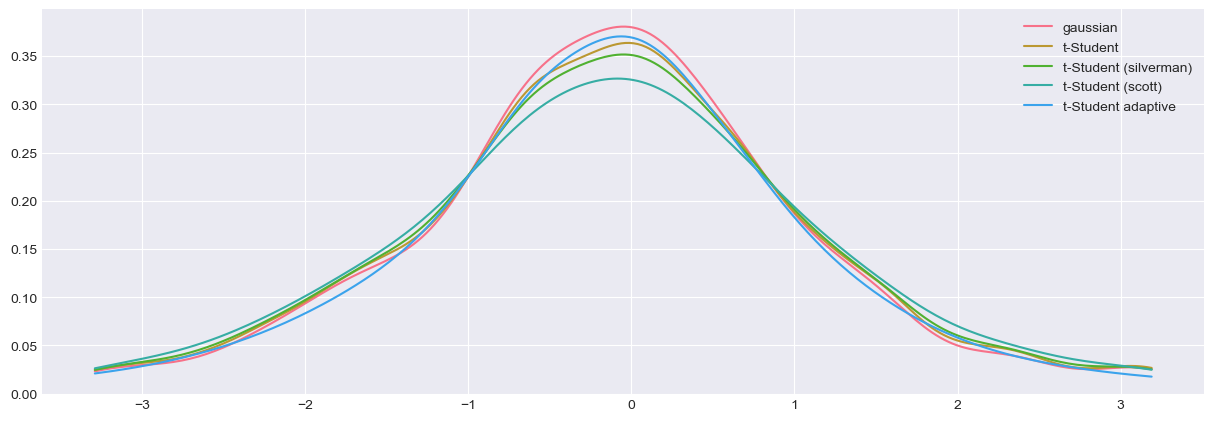

In [230]:
plt.figure(figsize=(15,5))

plt.plot(gaussian_kde.grid, gaussian_density, label="gaussian")
plt.plot(t_kde.grid, t_density, label="t-Student")
plt.plot(t2_kde.grid, t2_density, label="t-Student (silverman)")
plt.plot(t3_kde.grid, t3_density, label="t-Student (scott)")
plt.plot(t4_kde.grid, t4_density, label="t-Student adaptive")

plt.legend()

plt.show()